In [1]:
!pip install --user matplotlib

You are using pip version 18.1, however version 20.3b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
def epsilon_greedy(Q, S, epsilon):
    if random.uniform(0, 1) <= (1 - epsilon + (epsilon / len(Q[S]))):
        return np.argmax(Q[S])
    
    return random.randrange(len(Q[S]))
                            

In [4]:
def default_state_space(observation):
  return observation


In [5]:
def sarsa(env, gamma, number_of_episodes=500, step_size=0.1, epsilon=0.1, state_space_fn=default_state_space):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    sum_of_steps = []
    for episode in range(number_of_episodes):
        S = state_space_fn(env.reset())
        done = False
        step_count = 0
        A = epsilon_greedy(Q, S, epsilon)
        
        while not done:
            S_next, reward, done, info = env.step(A)
            S_next = state_space_fn(S_next)
            A_next = epsilon_greedy(Q, S_next, epsilon)
            step_count += 1
            
            if done:
                Q[S][A] = 0
                sum_of_steps.append(step_count)
            else:
                Q[S][A] = Q[S][A] + step_size * (reward + gamma * (Q[S_next][A_next] - Q[S][A]))
            
            S = S_next
            A = A_next
            
    plt.plot(range(number_of_episodes), sum_of_steps)

    plt.ylabel('Total number of steps')
    plt.xlabel('Episode')
    plt.show()
    
    return Q

In [6]:
def expected_sum(Q, S, epsilon):
    sum = 0
    number_of_actions = len(Q[S])
    A_optimal = np.argmax(Q[S])
    for A in range(number_of_actions):
        if A == A_optimal:
            sum += (1 - epsilon + epsilon / number_of_actions) * Q[S][A]
        else:
            sum += (epsilon / number_of_actions) * Q[S][A]
    return sum

In [7]:
def expected_sarsa(env, gamma, number_of_episodes=500, step_size=0.1, epsilon=0.1, state_space_fn=default_state_space):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    sum_of_steps = []
    
    for episode in range(number_of_episodes):
        S = state_space_fn(env.reset())
        done = False
        step_count = 0
        A = epsilon_greedy(Q, S, epsilon)
        
        while not done:
            S_next, reward, done, info = env.step(A)
            S_next = state_space_fn(S_next)
            A_next = epsilon_greedy(Q, S_next, epsilon)
            step_count += 1
            
            if done:
                Q[S][A] = 0
                sum_of_steps.append(step_count)
            else:
                Q[S][A] = Q[S][A] + step_size * (reward + gamma * (expected_sum(Q, S_next, epsilon) - Q[S][A]))
            
            S = S_next
            A = A_next
            
    plt.plot(range(number_of_episodes), sum_of_steps)
    plt.ylabel('Total number of steps')
    plt.xlabel('Episode')
    plt.show()
    return Q

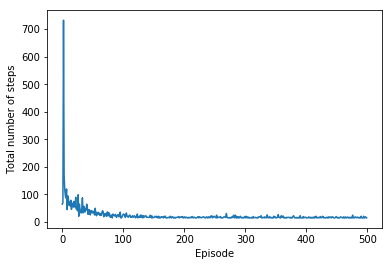

Total reward:  -15 in steps: 15


In [29]:
env = gym.make('CliffWalking-v0')
env.reset()

#Q = sarsa(env, 1.0, 500, epsilon=0.11, step_size= 0.2)
Q = expected_sarsa(env, 1.0, 500, epsilon=0.11, step_size= 0.2)

env.reset()
done = False
steps = 0
state = env.s
total_reward = 0
while not done:
    #env.render()
    state, reward, done, info = env.step(np.argmax(Q[state]))
    total_reward += reward
    steps += 1


env.close()
print('Total reward: ', total_reward, 'in steps:', steps)


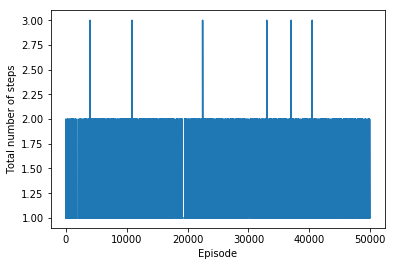

Total reward:  -1.0 in steps: 1


In [35]:
env = gym.make('Blackjack-v0')
env.reset()

#Q = sarsa(env, 0.9, 50000)
Q = expected_sarsa(env, 0.9, 50000)

env.reset()
done = False
steps = 0
total_reward = 0

while not done:
    state, reward, done, info = env.step(np.argmax(Q[state]))
    total_reward += reward
    steps += 1


print('Total reward: ', total_reward, 'in steps:', steps)

In [41]:
d_space = [np.linspace(-4.8, 4.8, 40),
           np.linspace(-2, 2, 40),
           np.linspace(-0.418,0.418, 48),
           np.linspace(-2, 2, 40)]

def d_cartpole_state_space(observation):
    return tuple(int(np.digitize(l, g)) for l, g in zip(observation, d_space))
    #return np.digitize(observation[0], cart_position) * cart_position_factor + np.digitize(observation[1], cart_velocity) * cart_velocity_factor + np.digitize(observation[2], pole_angle) * pole_angle_factor + np.digitize(observation[3], pole_angular_velocity) * pole_angular_velocity_factor



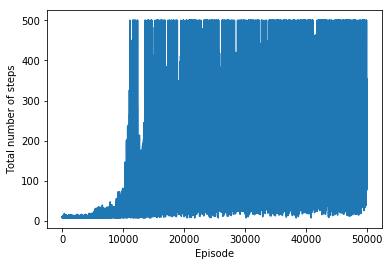

In [42]:
env = gym.make('CartPole-v1')
env.reset()

#Q = sarsa(env, 1.0, 50000, state_space_fn=d_cartpole_state_space)
Q = expected_sarsa(env, 1.0, 50000, state_space_fn=d_cartpole_state_space)

In [44]:
for r in range(100):
    state = d_cartpole_state_space(env.reset())
    done = False
    steps = 0

    total_reward = 0
    while not done:
        env.render()
        state, reward, done, info = env.step(np.argmax(Q[state]))
        state = d_cartpole_state_space(state)
        total_reward += reward
        steps += 1

    env.close()
    print('Total reward: ', total_reward, 'in steps:', steps)

Total reward:  143.0 in steps: 143
Total reward:  103.0 in steps: 103
Total reward:  183.0 in steps: 183
Total reward:  88.0 in steps: 88
Total reward:  110.0 in steps: 110
Total reward:  185.0 in steps: 185
Total reward:  177.0 in steps: 177
Total reward:  153.0 in steps: 153
Total reward:  153.0 in steps: 153
Total reward:  239.0 in steps: 239
Total reward:  153.0 in steps: 153
Total reward:  176.0 in steps: 176
Total reward:  167.0 in steps: 167
Total reward:  240.0 in steps: 240
Total reward:  218.0 in steps: 218
Total reward:  171.0 in steps: 171
Total reward:  212.0 in steps: 212
Total reward:  189.0 in steps: 189
Total reward:  53.0 in steps: 53
Total reward:  213.0 in steps: 213
Total reward:  127.0 in steps: 127
Total reward:  85.0 in steps: 85
Total reward:  159.0 in steps: 159
Total reward:  181.0 in steps: 181
Total reward:  173.0 in steps: 173
Total reward:  181.0 in steps: 181
Total reward:  88.0 in steps: 88
Total reward:  178.0 in steps: 178
Total reward:  70.0 in steps